# Setup

In [1]:
!pip install kaggle
!pip install wandb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

 86% 244M/285M [00:00<00:00, 728MB/s] 
100% 285M/285M [00:03<00:00, 84.6MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
import torch.nn.functional as F
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from copy import deepcopy
import wandb
import datetime

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac

print("Device available: ", device)

Device available:  cuda


In [6]:
config = {
    'batch_size': 256,
    'lr': 0.0005,
    'num_epochs': 30,
    'dropout': 0.3,
    'weight_decay': 1e-3,
    'model_name': 'Finalized_CNN'
}

In [7]:
run_name = f"{config['model_name']}_bs{config['batch_size']}_lr{config['lr']}_epochs{config['num_epochs']}_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}"
wandb.init(project="facial-expression-recognition", config=config, name=run_name, mode="online", resume="never")
data = pd.read_csv("train.csv")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gioeba (gioeba-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [8]:
data.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


# Preprocessing

In [9]:
class FERDataset(Dataset):
    def __init__(self, images, labels, augment=False):
        self.images = images
        self.labels = labels
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].clone()
        label = self.labels[idx]

        if self.augment:
            if torch.rand(1).item() > 0.5:
                image = torch.flip(image, dims=[2])

            if torch.rand(1).item() > 0.5:
                angle = torch.empty(1).uniform_(-10, 10).item()
                grid = F.affine_grid(torch.tensor([[[np.cos(np.radians(angle)), -np.sin(np.radians(angle)), 0],
                                                    [np.sin(np.radians(angle)),  np.cos(np.radians(angle)), 0]]],
                                                 dtype=torch.float32),
                                     image.unsqueeze(0).size(), align_corners=False)
                image = F.grid_sample(image.unsqueeze(0), grid, align_corners=False).squeeze(0)

            if torch.rand(1).item() > 0.5:
                shift_x = torch.randint(-1, 2, (1,)).item()
                shift_y = torch.randint(-1, 2, (1,)).item()
                image = torch.roll(image, shifts=(shift_y, shift_x), dims=(1, 2))

            if torch.rand(1).item() > 0.7:
                noise = torch.randn_like(image) * 0.01
                image = image + noise
                image = torch.clamp(image, -3, 3)

            if torch.rand(1).item() > 0.7:
                brightness_factor = torch.empty(1).uniform_(0.95, 1.05).item()
                image = image * brightness_factor

            if torch.rand(1).item() > 0.8:
                mean_val = image.mean()
                contrast_factor = torch.empty(1).uniform_(0.9, 1.1).item()
                image = (image - mean_val) * contrast_factor + mean_val

        return image, label

In [10]:
pixels = data['pixels'].apply(lambda x: np.fromstring(x, sep=' ', dtype=np.float32))
images = np.stack(pixels.to_numpy()) / 255.0
images = torch.tensor(images.reshape(-1, 1, 48, 48), dtype=torch.float32)
labels = torch.tensor(data['emotion'].values, dtype=torch.long)

X_temp, X_test, y_temp, y_test = train_test_split(
    images, labels, test_size=0.15, stratify=labels, random_state=42
)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
)

mean_image = X_train_raw.mean(dim=0, keepdim=True)
X_train = X_train_raw - mean_image
X_val = X_val_raw - mean_image
X_test_norm = X_test - mean_image

In [11]:
train_dataset = FERDataset(X_train, y_train, augment=True)
val_dataset = FERDataset(X_val, y_val, augment=False)
test_dataset = FERDataset(X_test_norm, y_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

# Model

In [12]:
class FERNet(nn.Module):
    def __init__(self):
        super(FERNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
        )

        self.dropout = nn.Dropout(config['dropout'])
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 256),
            nn.LeakyReLU(0.1),
            self.dropout,
            nn.Linear(256, 7)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Training

In [13]:
model = FERNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=4
)
criterion = nn.CrossEntropyLoss()
wandb.watch(model, criterion, log="all", log_freq=100)

train_accs, val_accs = [], []
train_losses, val_losses = [], []
best_val_acc = 0
best_model = deepcopy(model.state_dict())

for epoch in range(config['num_epochs']):
    model.train()
    train_loss_total = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss_total += loss.item()

    model.eval()
    with torch.no_grad():
        train_preds, train_true = [], []
        train_loss_total_eval = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            train_loss_total_eval += criterion(out, y).item()
            preds = out.argmax(dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_true.extend(y.cpu().numpy())

        val_preds, val_true = [], []
        val_loss_total = 0
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            val_loss_total += criterion(out, y).item()
            preds = out.argmax(dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_true.extend(y.cpu().numpy())

    train_acc = accuracy_score(train_true, train_preds)
    val_acc = accuracy_score(val_true, val_preds)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss_total_eval / len(train_loader))
    val_losses.append(val_loss_total / len(val_loader))

    val_loss_avg = val_loss_total / len(val_loader)

    scheduler.step(val_loss_avg)

    print(f"Epoch {epoch+1}/{config['num_epochs']} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    wandb.log({
        "epoch": epoch + 1,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "train_loss": train_losses[-1],
        "val_loss": val_losses[-1],
        "lr": optimizer.param_groups[0]['lr'],
    })

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = deepcopy(model.state_dict())

Epoch 1/30 - Train Acc: 0.3524 - Val Acc: 0.3557
Epoch 2/30 - Train Acc: 0.3821 - Val Acc: 0.3826
Epoch 3/30 - Train Acc: 0.4205 - Val Acc: 0.4179
Epoch 4/30 - Train Acc: 0.4183 - Val Acc: 0.4198
Epoch 5/30 - Train Acc: 0.4560 - Val Acc: 0.4490
Epoch 6/30 - Train Acc: 0.4740 - Val Acc: 0.4741
Epoch 7/30 - Train Acc: 0.4863 - Val Acc: 0.4866
Epoch 8/30 - Train Acc: 0.4941 - Val Acc: 0.4890
Epoch 9/30 - Train Acc: 0.5085 - Val Acc: 0.5045
Epoch 10/30 - Train Acc: 0.5153 - Val Acc: 0.5113
Epoch 11/30 - Train Acc: 0.5242 - Val Acc: 0.5136
Epoch 12/30 - Train Acc: 0.5243 - Val Acc: 0.5212
Epoch 13/30 - Train Acc: 0.5405 - Val Acc: 0.5277
Epoch 14/30 - Train Acc: 0.5386 - Val Acc: 0.5238
Epoch 15/30 - Train Acc: 0.5424 - Val Acc: 0.5342
Epoch 16/30 - Train Acc: 0.5579 - Val Acc: 0.5398
Epoch 17/30 - Train Acc: 0.5657 - Val Acc: 0.5512
Epoch 18/30 - Train Acc: 0.5621 - Val Acc: 0.5466
Epoch 19/30 - Train Acc: 0.5677 - Val Acc: 0.5491
Epoch 20/30 - Train Acc: 0.5677 - Val Acc: 0.5521
Epoch 21/

# Final test

In [14]:
model.load_state_dict(best_model)
model.eval()

val_preds, val_true = [], []
with torch.no_grad():
    for X, y in val_loader:
        X, y = X.to(device), y.to(device)
        out = model(X).argmax(dim=1)
        val_preds.extend(out.cpu().numpy())
        val_true.extend(y.cpu().numpy())

val_acc = accuracy_score(val_true, val_preds)
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")
wandb.log({"final_val_acc": val_acc})

Final Validation Accuracy: 58.72%


In [15]:
model.load_state_dict(best_model)
model.eval()

test_preds, test_true = [], []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        out = model(X).argmax(dim=1)
        test_preds.extend(out.cpu().numpy())
        test_true.extend(y.cpu().numpy())

test_acc = accuracy_score(test_true, test_preds)
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")
wandb.log({"final_test_acc": test_acc})

Final Test Accuracy: 58.72%


In [16]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
final_test_acc,▁
final_val_acc,▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇██▇█
train_loss,█▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
val_acc,▁▂▃▃▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇████
val_loss,█▇▆▆▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
epoch,30
final_test_acc,0.58718
final_val_acc,0.58718


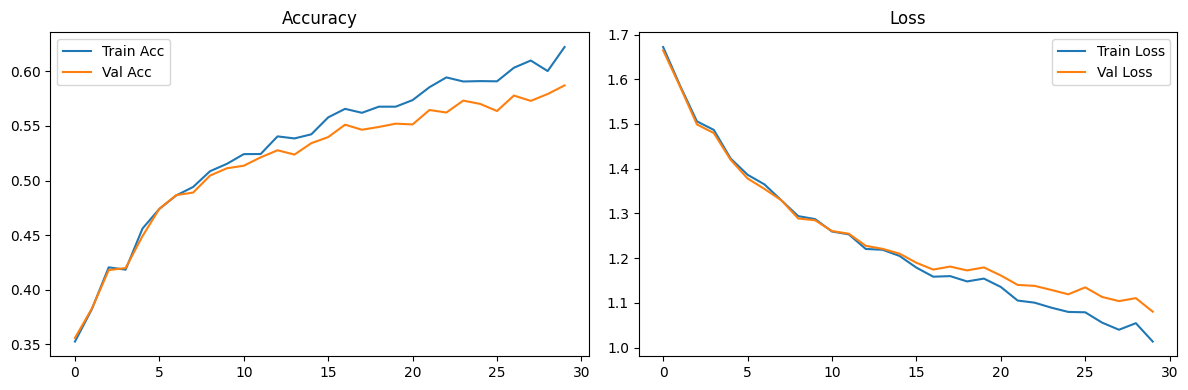

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()